# Visualise Results
This Notebook downloads experiment data from comet-ml and aggregates or visualises them for the thesis.

In [1]:
from comet_ml.api import API
import comet_ml
import pandas as pd
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt
# set default plt figsize to (12,6)
plt.rcParams["figure.figsize"] = (12, 6)
pd.set_option('display.colheader_justify', 'center')
# Set default font sizes
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['legend.title_fontsize'] = 18


# Initialize the Comet API with API key
api_key = "GAzEuNsoYVpPXO2ryeTk7C1o7"
api = API(api_key=api_key)

In [2]:
def get_experiments_results_data(workspace, project_name, experiment_ids):
    # Get the list of experiments in the project
    result_data = []
    for k, v in experiment_ids.items():
        experiment = api.get(workspace=workspace,
                             project_name=project_name, experiment=v)
        print(experiment.id)
        print(experiment.name)
        # You can also fetch individual metrics, parameters, etc.
        metrics_valid_mrr = experiment.get_metrics(["valid_mrr"])
        metrics_test_mrr = experiment.get_metrics(["test_mrr"])
        max_valid_mrr_value = float('-inf')
        max_epoch = None

        for record in metrics_valid_mrr:
            metric_value = float(record['metricValue'])
            if metric_value > max_valid_mrr_value:
                max_valid_mrr_value = metric_value
                max_epoch = record['epoch']

        print(f"Max valid_mrr: {max_valid_mrr_value}, Epoch: {max_epoch}")
        for record in metrics_test_mrr:
            if record['epoch'] == max_epoch:
                metric_test_mrr_epoch = float(record['metricValue'])
                break
        print(f"Max test_mrr: {metric_test_mrr_epoch}, Epoch: {max_epoch}")

        result_data.append({"name": k, "key": experiment.id, "max_valid_mrr": max_valid_mrr_value,
                           "test_mrr": metric_test_mrr_epoch, "epoch": max_epoch})

    return result_data


def plot_training_curves(df_mrr, title="MRR Curves", visualize_test_mrr=True):
    plt.figure(figsize=(10, 6))
    if visualize_test_mrr:
        sns.lineplot(df_mrr[df_mrr["metricName"] == "test_mrr"], x="epoch",
                     y="metricValue", label="test_mrr", linestyle="dashed", color="red", alpha=0.7)
    sns.lineplot(df_mrr[df_mrr["metricName"] == "train_mrr"],
                 x="epoch", y="metricValue", label="train_mrr", color="green")
    sns.lineplot(df_mrr[df_mrr["metricName"] == "valid_mrr"],
                 x="epoch", y="metricValue", label="valid_mrr", color="blue")

    plt.ylim(0, 1)
    plt.xlabel('Epochs')
    plt.ylabel('MRR')
    plt.title(title)
    plt.legend()
    plt.show()


def plot_training_curves_loss_auc(df_mrr, title="MRR Curves", y_axis="Metrics", ):
    plt.figure(figsize=(10, 6))
    sns.lineplot(df_mrr[df_mrr["metricName"] == "train_mrr"],
                 x="epoch", y="metricValue", label="Train MRR", color="blue")
    sns.lineplot(df_mrr[df_mrr["metricName"] == "train_rocauc"],
                 x="epoch", y="metricValue", label="AUROC", color="orange")
    sns.lineplot(df_mrr[df_mrr["metricName"] == "loss_epoch"], x="epoch",
                 y="metricValue", label="Negative-Log-\nLikelihood-Loss", color="green")

    plt.ylim(0, 1)
    plt.xlabel('Epochs')
    plt.ylabel(y_axis)
    plt.title(title)
    plt.legend()
    plt.show()
def get_experiments_data(workspace, project_name, experiment_ids, other_losses=False, epoch_loss=False):
    # Get the list of experiments in the project
    metrics_data = []
    for k, v in experiment_ids.items():
        experiment = api.get(workspace=workspace,
                             project_name=project_name, experiment=v)
        print(experiment.id)
        print(experiment.name)
        # You can also fetch individual metrics, parameters, etc.
        train_mrr = pd.DataFrame(experiment.get_metrics("train_mrr"))[
            ['metricName', 'metricValue', 'epoch', 'timestamp']]
        valid_mrr = pd.DataFrame(experiment.get_metrics("valid_mrr"))[
            ['metricName', 'metricValue', 'epoch', 'timestamp']]
        test_mrr = pd.DataFrame(experiment.get_metrics("test_mrr"))[
            ['metricName', 'metricValue', 'epoch', 'timestamp']]
        train_loss = pd.DataFrame(experiment.get_metrics("loss_epoch"))[
            ['metricName', 'metricValue', 'epoch', 'timestamp']]

        if other_losses:
            valid_loss = pd.DataFrame(experiment.get_metrics("valid_loss"))[
                ['metricName', 'metricValue', 'epoch', 'timestamp']]
            test_loss = pd.DataFrame(experiment.get_metrics("test_loss"))[
                ['metricName', 'metricValue', 'epoch', 'timestamp']]
            metrics = pd.concat(
                [train_mrr, valid_mrr, test_mrr, train_loss, valid_loss, test_loss])
        elif epoch_loss:
            epoch_loss = pd.DataFrame(experiment.get_metrics("loss_epoch"))[
                ['metricName', 'metricValue', 'epoch', 'timestamp']]
            auc = pd.DataFrame(experiment.get_metrics("train_rocauc"))[
                ['metricName', 'metricValue', 'epoch', 'timestamp']]
            metrics = pd.concat(
                [train_mrr, valid_mrr, test_mrr, epoch_loss, auc])
        else:
            metrics = pd.concat([train_mrr, valid_mrr, test_mrr, train_loss])
        metrics_data.append(
            {"name": k, "key": experiment.id, "metrics": metrics})
    return metrics_data

## Reference Models
Model data for reference models (gcn and gin, sage) is downloaded and visualised.

In [8]:
experiment_ids = {'GCN reference':'15813a0135394f5fbf73e376f46b4cf9',
                  'GIN reference':'ea2202bee86a4394adbcbc3c48b47ea9',
                  'SAGE reference':'90b05358d9ec47a481eb81ba192b1fad'}
workspace = "tmandelz-outlook-com's Organisation"
project_name = "transfer-learning-link-prediction"



experiment_data = get_experiments_data(workspace=workspace,project_name=project_name,experiment_ids=experiment_ids)
results_data = get_experiments_results_data(workspace=workspace,project_name=project_name,experiment_ids=experiment_ids)

15813a0135394f5fbf73e376f46b4cf9
Reference_GCN
ea2202bee86a4394adbcbc3c48b47ea9
Reference_GIN
90b05358d9ec47a481eb81ba192b1fad
Reference_SAGE
15813a0135394f5fbf73e376f46b4cf9
Reference_GCN
Max valid_mrr: 0.8422127366065979, Epoch: 2252
Max test_mrr: 0.8392544388771057, Epoch: 2252
ea2202bee86a4394adbcbc3c48b47ea9
Reference_GIN
Max valid_mrr: 0.8923896551132202, Epoch: 2346
Max test_mrr: 0.8892157673835754, Epoch: 2346
90b05358d9ec47a481eb81ba192b1fad
Reference_SAGE
Max valid_mrr: 0.889106273651123, Epoch: 2436
Max test_mrr: 0.8902245759963989, Epoch: 2436


In [28]:
experiment_ids_2 = {'GCN reference 2':'23ddab6f18b34bdaa97fe203614553df',
                  'GIN reference 2':'e945a7824ad2499c921a028738067cf0',
                  'SAGE reference 2':'830bf7d7d66446f2bbb34d7d7b80c972'}

experiment_data_2 = get_experiments_data(workspace=workspace,project_name=project_name,experiment_ids=experiment_ids_2)
results_data_2 = get_experiments_results_data(workspace=workspace,project_name=project_name,experiment_ids=experiment_ids_2)

23ddab6f18b34bdaa97fe203614553df
Reference_GCN_2
e945a7824ad2499c921a028738067cf0
Reference_GIN_2
830bf7d7d66446f2bbb34d7d7b80c972
Reference_SAGE_2
23ddab6f18b34bdaa97fe203614553df
Reference_GCN_2
Max valid_mrr: 0.8522635698318481, Epoch: 2171
Max test_mrr: 0.852189838886261, Epoch: 2171
e945a7824ad2499c921a028738067cf0
Reference_GIN_2
Max valid_mrr: 0.8970863819122314, Epoch: 2485
Max test_mrr: 0.8966202735900879, Epoch: 2485
830bf7d7d66446f2bbb34d7d7b80c972
Reference_SAGE_2
Max valid_mrr: 0.8923885226249695, Epoch: 2362
Max test_mrr: 0.8914207220077515, Epoch: 2362


In [29]:

# get best 
gcn_df = experiment_data[0]['metrics']
gcn_df2 = experiment_data_2[0]['metrics'][:-1]
gcn_df2.loc[:,"epoch"] += gcn_df["epoch"].max()
gcn_df = pd.concat([gcn_df,gcn_df2]).reset_index(drop=True)

firstepoch_test_mrr_gcn_ref = float(gcn_df[gcn_df['metricName'] == "test_mrr"].iloc[0]['metricValue'])
finalepoch_test_mrr_gcn_ref = float(gcn_df[gcn_df['metricName'] == "test_mrr"].iloc[1800]['metricValue']) # TODO change

gin_df = experiment_data[1]['metrics']
gin_df2 = experiment_data_2[1]['metrics'][:-1]
gin_df2.loc[:,"epoch"] += gin_df["epoch"].max()
gin_df = pd.concat([gin_df,gin_df2]).reset_index(drop=True)

firstepoch_test_mrr_gin_ref = float(gin_df[gin_df['metricName'] == "test_mrr"].iloc[0]['metricValue'])
finalepoch_test_mrr_gin_ref = float(gin_df[gin_df['metricName'] == "test_mrr"].iloc[1800]['metricValue']) # TODO change

sage_df = experiment_data[2]['metrics']
sage_df2 = experiment_data_2[2]['metrics'][:-1]
sage_df2.loc[:,"epoch"] += sage_df["epoch"].max()
sage_df = pd.concat([sage_df,sage_df2]).reset_index(drop=True)

firstepoch_test_mrr_sage_ref = float(sage_df[sage_df['metricName'] == "test_mrr"].iloc[0]['metricValue'])
finalepoch_test_mrr_sage_ref = float(sage_df[sage_df['metricName'] == "test_mrr"].iloc[2300]['metricValue']) # TODO change

### Plot MRR Curves
Plot MRR Curves together into a single visualisation.

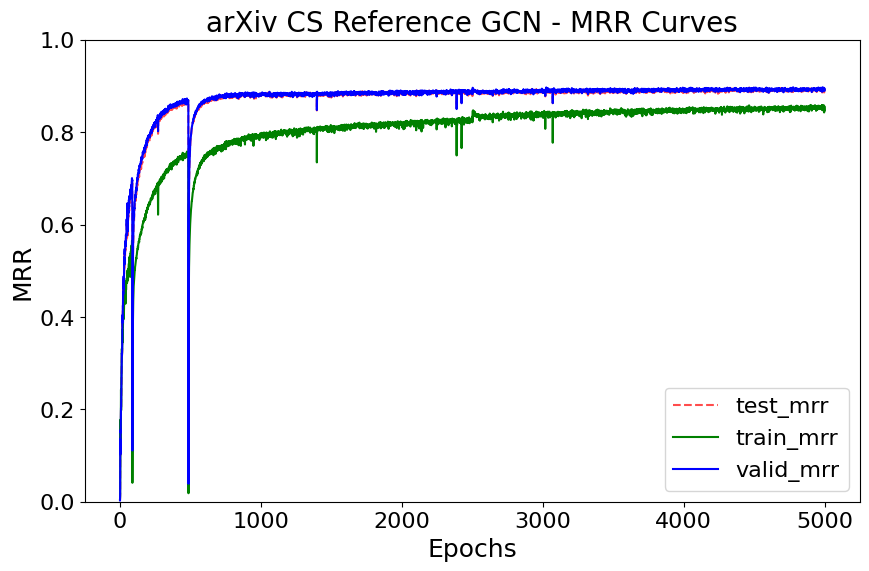

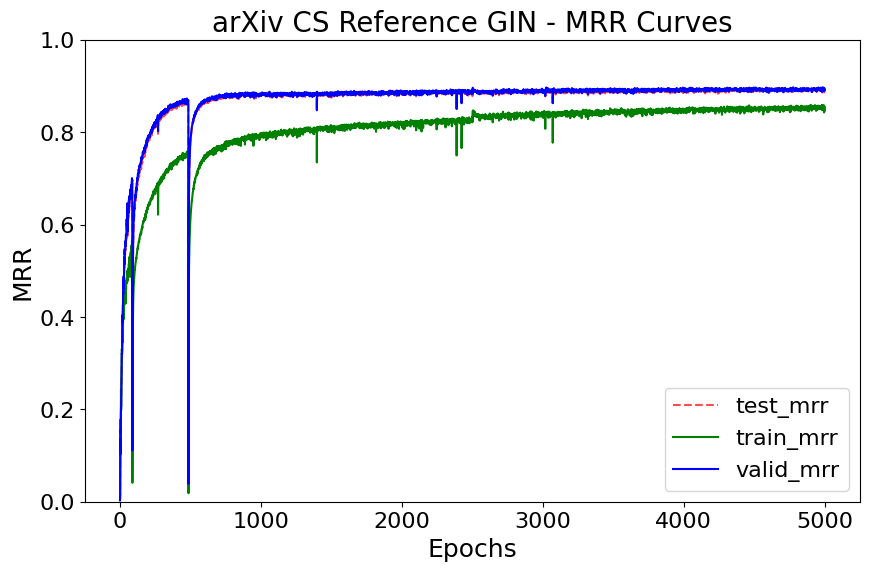

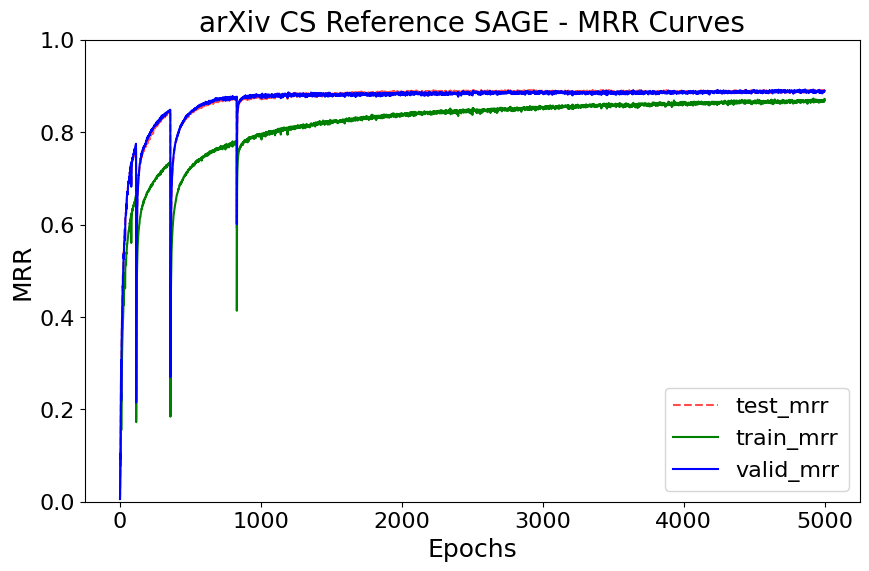

In [30]:
gcn_df['metricValue'] = gcn_df['metricValue'].astype(float)
gin_df['metricValue'] = gin_df['metricValue'].astype(float)
sage_df['metricValue'] = sage_df['metricValue'].astype(float)

plot_training_curves(gin_df, "arXiv CS Reference GCN - MRR Curves")
plot_training_curves(gin_df, "arXiv CS Reference GIN - MRR Curves")
plot_training_curves(sage_df, "arXiv CS Reference SAGE - MRR Curves")

## Finetuning Models
Model data for Finetuning models is downloaded and visualised.

In [31]:
experiment_ids = {'GCN finetune':'0b67c8710eaa4785bfc1579a341a21db',
                  'GIN finetune':'f5f2c85520b44bb580881868e07b2d76',
                  'SAGE finetune':'dc44f38332824315a070238c399a08fe'} # TODO change gin
workspace = "tmandelz-outlook-com's Organisation"
project_name = "transfer-learning-link-prediction"

experiment_data = get_experiments_data(workspace=workspace,project_name=project_name,experiment_ids=experiment_ids)
results_data = get_experiments_results_data(workspace=workspace,project_name=project_name,experiment_ids=experiment_ids)

0b67c8710eaa4785bfc1579a341a21db
Finetune_GCN
dc44f38332824315a070238c399a08fe
Finetune_SAGE
dc44f38332824315a070238c399a08fe
Finetune_SAGE
0b67c8710eaa4785bfc1579a341a21db
Finetune_GCN
Max valid_mrr: 0.8525508642196655, Epoch: 508
Max test_mrr: 0.8480827212333679, Epoch: 508
dc44f38332824315a070238c399a08fe
Finetune_SAGE
Max valid_mrr: 0.8895868062973022, Epoch: 2082
Max test_mrr: 0.8851931095123291, Epoch: 2082
dc44f38332824315a070238c399a08fe
Finetune_SAGE
Max valid_mrr: 0.8895868062973022, Epoch: 2082
Max test_mrr: 0.8851931095123291, Epoch: 2082


### Mean Difference Validation and Train MRR
Calculate the mean difference from validation to train MRR.

In [16]:
df_fine_val_train_mrr =experiment_data[0]['metrics']
df_fine_val_train_mrr = df_fine_val_train_mrr[df_fine_val_train_mrr["metricName"].isin(["train_mrr","valid_mrr"])]
np.round(np.mean(np.array(df_fine_val_train_mrr.pivot(columns=["metricName"])['metricValue']['valid_mrr'],dtype=float) - np.array(df_fine_val_train_mrr.pivot(columns=["metricName"])['metricValue']['train_mrr'],dtype=float)),4)


0.1053

### Plot MRR Curves
Plot MRR Curves together into a single visualisation.

In [35]:
gcn_df_fine = experiment_data[0]['metrics']
firstepoch_test_mrr_gcn_fine = float(gcn_df_fine[gcn_df_fine['metricName'] == "test_mrr"].iloc[0]['metricValue'])
finalepoch_test_mrr_gcn_fine = float(gcn_df_fine[gcn_df_fine['metricName'] == "test_mrr"].iloc[1896]['metricValue']) # TODO change

gin_df_fine = experiment_data[1]['metrics']
firstepoch_test_mrr_gin_fine = float(gin_df_fine[gin_df_fine['metricName'] == "test_mrr"].iloc[0]['metricValue'])
finalepoch_test_mrr_gin_fine = float(gin_df_fine[gin_df_fine['metricName'] == "test_mrr"].iloc[1397]['metricValue']) # TODO change

sage_df_fine = experiment_data[2]['metrics']
firstepoch_test_mrr_sage_fine = float(sage_df_fine[sage_df_fine['metricName'] == "test_mrr"].iloc[0]['metricValue'])
finalepoch_test_mrr_sage_fine = float(sage_df_fine[sage_df_fine['metricName'] == "test_mrr"].iloc[1397]['metricValue']) # TODO change

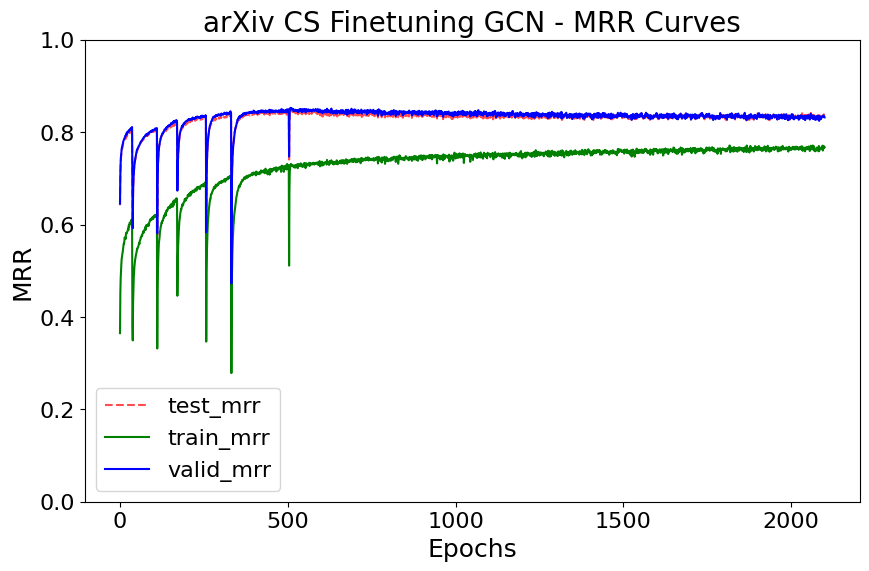

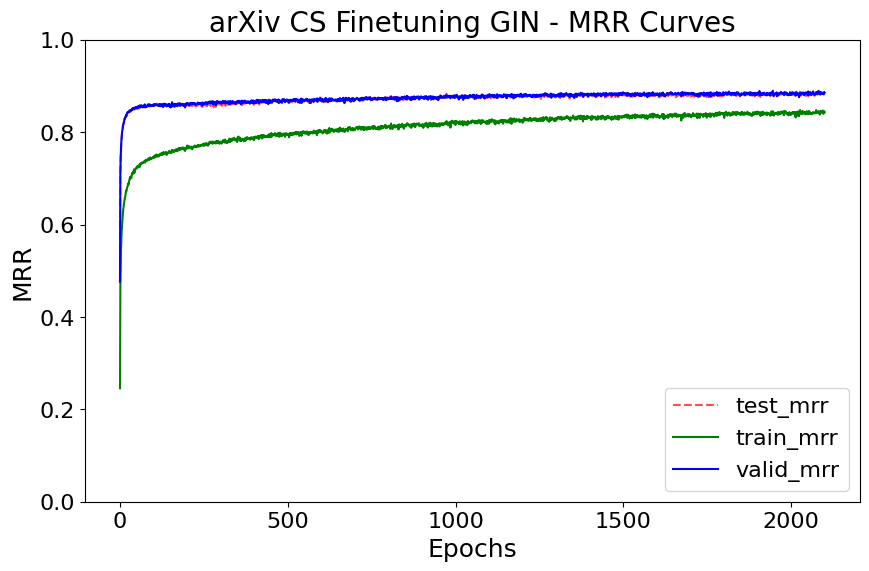

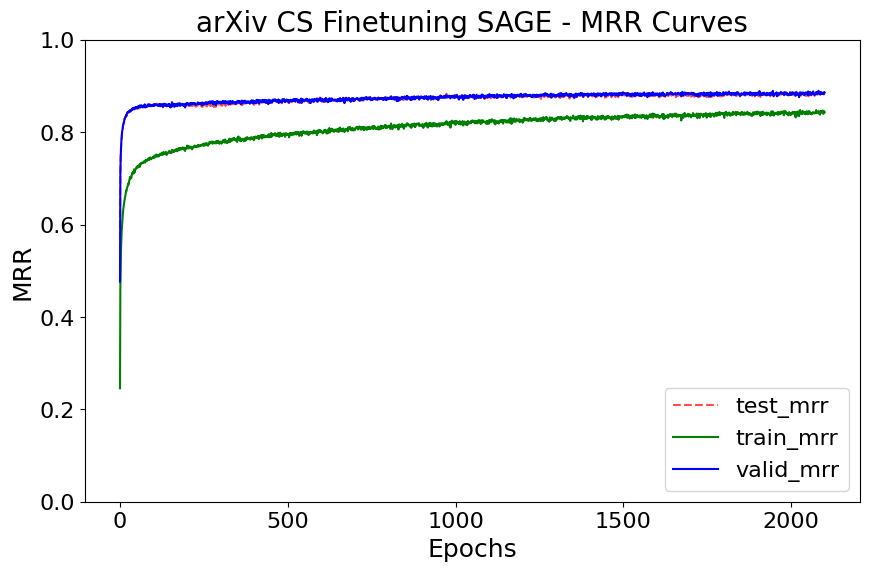

In [36]:
gcn_df_fine['metricValue'] = gcn_df_fine['metricValue'].astype(float)
gin_df_fine['metricValue'] = gin_df_fine['metricValue'].astype(float)
sage_df_fine['metricValue'] = sage_df_fine['metricValue'].astype(float)

plot_training_curves(gcn_df_fine, "arXiv CS Finetuning GCN - MRR Curves")
plot_training_curves(gin_df_fine, "arXiv CS Finetuning GIN - MRR Curves")
plot_training_curves(sage_df_fine, "arXiv CS Finetuning SAGE - MRR Curves")

## Compute Time Differences GCN Reference / Finetune
Computing time differences between the reference and finetuned model

In [37]:
gcn_df['timestamp'] = gcn_df['timestamp']/1000
gcn_df['timestamp'] = pd.to_datetime(gcn_df['timestamp'], unit='s')
gcn_df['minute_diff'] = (gcn_df['timestamp'] - gcn_df['timestamp'].iloc[0]).dt.total_seconds() / 60 / 60

gcn_df_fine['timestamp'] = gcn_df_fine['timestamp']/1000
gcn_df_fine['timestamp'] = pd.to_datetime(gcn_df_fine['timestamp'], unit='s')
gcn_df_fine['minute_diff'] = (gcn_df_fine['timestamp'] - gcn_df_fine['timestamp'].iloc[0]).dt.total_seconds() / 60 / 60

gin_df['timestamp'] = gin_df['timestamp']/1000
gin_df['timestamp'] = pd.to_datetime(gin_df['timestamp'], unit='s')
gin_df['minute_diff'] = (gin_df['timestamp'] - gin_df['timestamp'].iloc[0]).dt.total_seconds() / 60 / 60

gin_df_fine['timestamp'] = gin_df_fine['timestamp']/1000
gin_df_fine['timestamp'] = pd.to_datetime(gin_df_fine['timestamp'], unit='s')
gin_df_fine['minute_diff'] = (gin_df_fine['timestamp'] - gin_df_fine['timestamp'].iloc[0]).dt.total_seconds() / 60 / 60

sage_df['timestamp'] = sage_df['timestamp']/1000
sage_df['timestamp'] = pd.to_datetime(sage_df['timestamp'], unit='s')
sage_df['minute_diff'] = (sage_df['timestamp'] - sage_df['timestamp'].iloc[0]).dt.total_seconds() / 60 / 60

sage_df_fine['timestamp'] = sage_df_fine['timestamp']/1000
sage_df_fine['timestamp'] = pd.to_datetime(sage_df_fine['timestamp'], unit='s')
sage_df_fine['minute_diff'] = (sage_df_fine['timestamp'] - sage_df_fine['timestamp'].iloc[0]).dt.total_seconds() / 60 / 60

In [38]:
# get training step where the reference model was the first time over 10 hours (GCN)
gcn_df_test_mrr = gcn_df[gcn_df['metricName'] == "test_mrr"]
gcn_df_test_mrr[gcn_df_test_mrr['minute_diff'] <=10.01][-1:]


,metricName,metricValue,epoch,timestamp,minute_diff
6573,test_mrr,0.829274,1565,2024-12-11 10:44:46.382999897,10.006149


In [39]:
# get training step where the reference model was the first time over 10 hours (GIN)
gin_df_test_mrr = gin_df[gin_df['metricName'] == "test_mrr"]
gin_df_test_mrr[gin_df_test_mrr['minute_diff'] <=10.01][-1:]


,metricName,metricValue,epoch,timestamp,minute_diff
6598,test_mrr,0.880887,1596,2024-12-11 08:07:49.187999964,10.004825


In [40]:
# get training step where the reference model was the first time over 10 hours (SAGE)
sage_df_test_mrr = sage_df[sage_df['metricName'] == "test_mrr"]
sage_df_test_mrr[sage_df_test_mrr['minute_diff'] <=10.01][-1:]


,metricName,metricValue,epoch,timestamp,minute_diff
6646,test_mrr,0.881622,1644,2024-12-11 08:08:08.430999994,10.008308


In [41]:
# get training step where the finetuned model is as close as possible to the mrr of the above training step (GCN)
gcn_df_fine_test_mrr = gcn_df_fine[gcn_df_fine['metricName'] == "test_mrr"]
gcn_df_fine_test_mrr[gcn_df_fine_test_mrr['metricValue'] >= 0.823472][:1] # TODO Change hardcode

,metricName,metricValue,epoch,timestamp,minute_diff
205,test_mrr,0.82375,205,2024-12-16 21:37:15.263999939,1.516557


In [42]:
# get training step where the finetuned model is as close as possible to the mrr of the above training step (GIN)
gin_df_fine_test_mrr = gin_df_fine[gin_df_fine['metricName'] == "test_mrr"]
gin_df_fine_test_mrr[gin_df_fine_test_mrr['metricValue'] >= 0.860385] # TODO Change hardcode

,metricName,metricValue,epoch,timestamp,minute_diff
100,test_mrr,0.860761,100,2024-12-16 18:14:08.901999950,0.694968
103,test_mrr,0.860777,103,2024-12-16 18:15:18.270999908,0.714237
105,test_mrr,0.860482,105,2024-12-16 18:16:05.223999977,0.727279
109,test_mrr,0.861423,109,2024-12-16 18:17:38.267999887,0.753125
110,test_mrr,0.860876,110,2024-12-16 18:18:03.401000023,0.760106
...,...,...,...,...,...
2097,test_mrr,0.881529,2096,2024-12-17 06:28:53.490000010,12.940687
2098,test_mrr,0.882554,2097,2024-12-17 06:29:15.009999990,12.946664
2099,test_mrr,0.883528,2098,2024-12-17 06:29:35.427999973,12.952336
2100,test_mrr,0.885428,2099,2024-12-17 06:29:57.454999924,12.958455


In [43]:
# get training step where the finetuned model is as close as possible to the mrr of the above training step (GIN)
sage_df_fine_test_mrr = sage_df_fine[sage_df_fine['metricName'] == "test_mrr"]
sage_df_fine_test_mrr[sage_df_fine_test_mrr['metricValue'] >= 0.835385] # TODO Change hardcode

,metricName,metricValue,epoch,timestamp,minute_diff
18,test_mrr,0.836982,18,2024-12-16 17:40:15.440999985,0.130118
20,test_mrr,0.836742,20,2024-12-16 17:41:07.293999910,0.144521
21,test_mrr,0.839899,21,2024-12-16 17:41:34.042999983,0.151951
22,test_mrr,0.839663,22,2024-12-16 17:42:00.918999910,0.159417
23,test_mrr,0.839067,23,2024-12-16 17:42:25.986000061,0.166380
...,...,...,...,...,...
2097,test_mrr,0.881529,2096,2024-12-17 06:28:53.490000010,12.940687
2098,test_mrr,0.882554,2097,2024-12-17 06:29:15.009999990,12.946664
2099,test_mrr,0.883528,2098,2024-12-17 06:29:35.427999973,12.952336
2100,test_mrr,0.885428,2099,2024-12-17 06:29:57.454999924,12.958455


### Plotting the training time
Plotting the training time and especially the intersection points for the equivalent metrics.


C:\Users\chant\AppData\Local\Temp\ipykernel_25676\3594899013.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(10,0.823472,'ro', markersize=7,color="blue", markeredgecolor='black', label='Reference - 10 Hour Training')
C:\Users\chant\AppData\Local\Temp\ipykernel_25676\3594899013.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(2.267009,0.823030,'ro', markersize=7,color="red", markeredgecolor='black', label='Finetuning - Intersection Point')


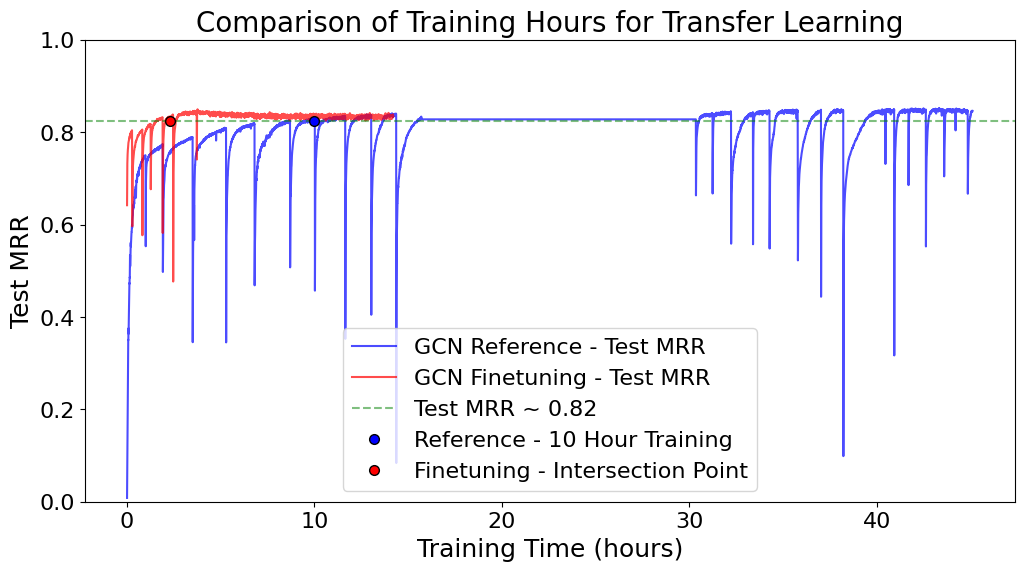

In [44]:
sns.lineplot(gcn_df[gcn_df["metricName"] == "test_mrr"],x="minute_diff",y="metricValue", label="GCN Reference - Test MRR",color="blue",alpha=0.7)
sns.lineplot(gcn_df_fine[gcn_df_fine["metricName"] == "test_mrr"],x="minute_diff",y="metricValue", label="GCN Finetuning - Test MRR",color="red",alpha=0.7)
plt.ylim(0,1)
plt.xlabel('Training Time (hours)')
plt.ylabel('Test MRR')
plt.title("Comparison of Training Hours for Transfer Learning")
plt.axhline(0.823472,alpha=0.5,color="green",linestyle="dashed",label="Test MRR ~ 0.82")
plt.plot(10,0.823472,'ro', markersize=7,color="blue", markeredgecolor='black', label='Reference - 10 Hour Training')
plt.plot(2.267009,0.823030,'ro', markersize=7,color="red", markeredgecolor='black', label='Finetuning - Intersection Point')
plt.legend()

plt.show()

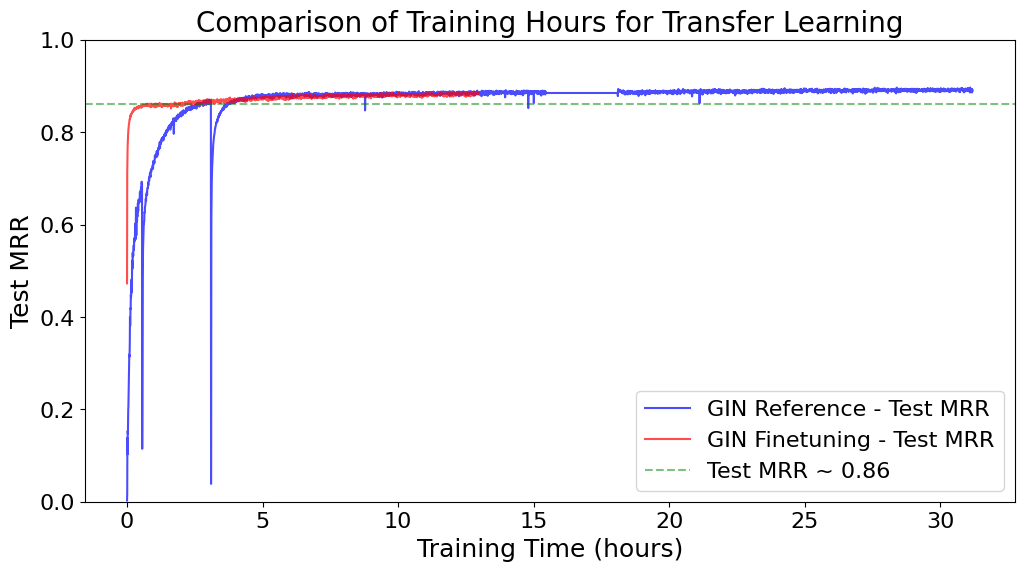

In [45]:
sns.lineplot(gin_df[gin_df["metricName"] == "test_mrr"],x="minute_diff",y="metricValue", label="GIN Reference - Test MRR",color="blue",alpha=0.7)
sns.lineplot(gin_df_fine[gin_df_fine["metricName"] == "test_mrr"],x="minute_diff",y="metricValue", label="GIN Finetuning - Test MRR",color="red",alpha=0.7)
plt.ylim(0,1)
plt.xlabel('Training Time (hours)')
plt.ylabel('Test MRR')
plt.title("Comparison of Training Hours for Transfer Learning")
plt.axhline(0.860385,alpha=0.5,color="green",linestyle="dashed",label="Test MRR ~ 0.86") # TODO Change hardcoded
plt.legend()

plt.show()

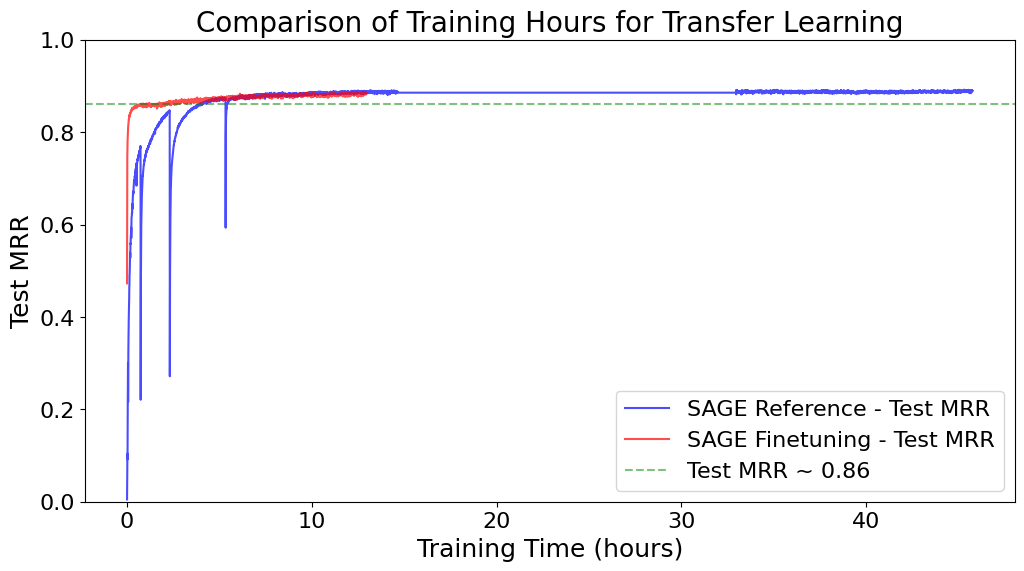

In [46]:
sns.lineplot(sage_df[sage_df["metricName"] == "test_mrr"],x="minute_diff",y="metricValue", label="SAGE Reference - Test MRR",color="blue",alpha=0.7)
sns.lineplot(sage_df_fine[sage_df_fine["metricName"] == "test_mrr"],x="minute_diff",y="metricValue", label="SAGE Finetuning - Test MRR",color="red",alpha=0.7)
plt.ylim(0,1)
plt.xlabel('Training Time (hours)')
plt.ylabel('Test MRR')
plt.title("Comparison of Training Hours for Transfer Learning")
plt.axhline(0.860385,alpha=0.5,color="green",linestyle="dashed",label="Test MRR ~ 0.86") # TODO Change hardcoded
plt.legend()

plt.show()

## Visualize Finetune vs Reference

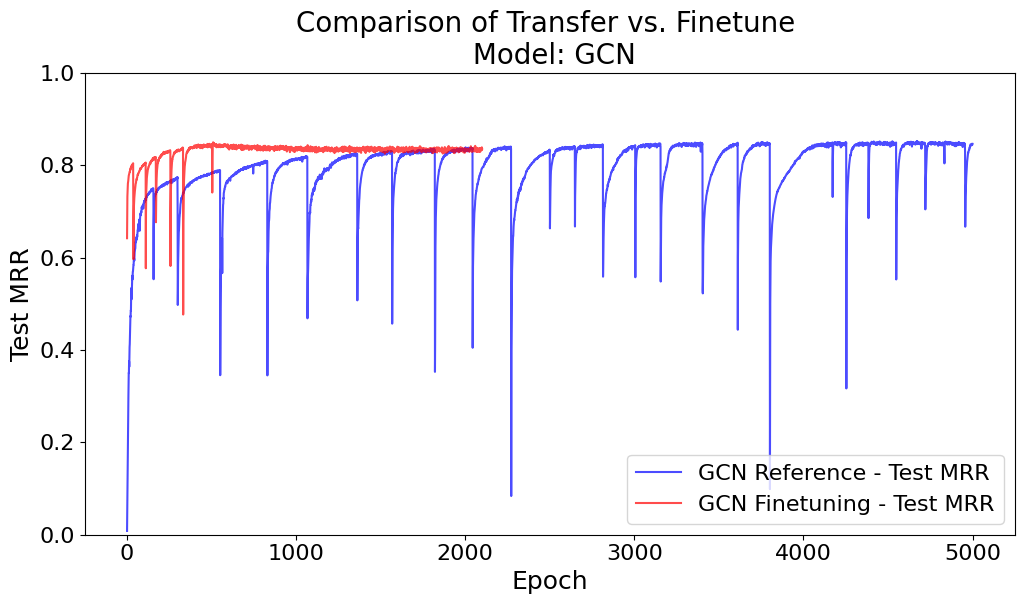

In [47]:
sns.lineplot(gcn_df[gcn_df["metricName"] == "test_mrr"],x="epoch",y="metricValue", label="GCN Reference - Test MRR",color="blue",alpha=0.7)
sns.lineplot(gcn_df_fine[gcn_df_fine["metricName"] == "test_mrr"],x="epoch",y="metricValue", label="GCN Finetuning - Test MRR",color="red",alpha=0.7)
plt.ylim(0,1)
plt.xlabel('Epoch')
plt.ylabel('Test MRR')
plt.title("Comparison of Transfer vs. Finetune \n Model: GCN")
plt.legend()
plt.show()

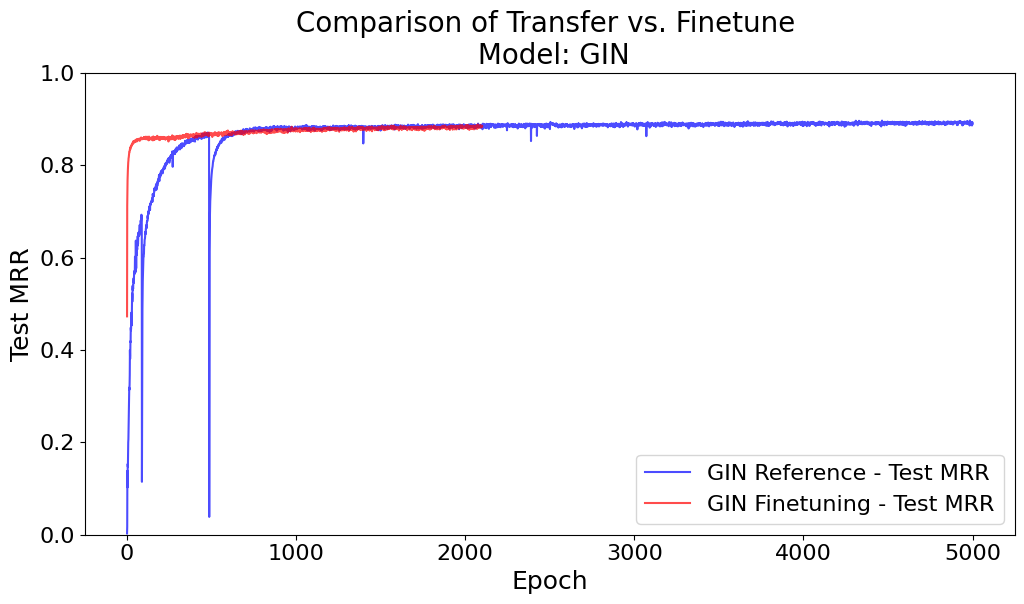

In [48]:
sns.lineplot(gin_df[gin_df["metricName"] == "test_mrr"],x="epoch",y="metricValue", label="GIN Reference - Test MRR",color="blue",alpha=0.7)
sns.lineplot(gin_df_fine[gin_df_fine["metricName"] == "test_mrr"],x="epoch",y="metricValue", label="GIN Finetuning - Test MRR",color="red",alpha=0.7)
plt.ylim(0,1)
plt.xlabel('Epoch')
plt.ylabel('Test MRR')
plt.title("Comparison of Transfer vs. Finetune \n Model: GIN")
plt.legend()
plt.show()

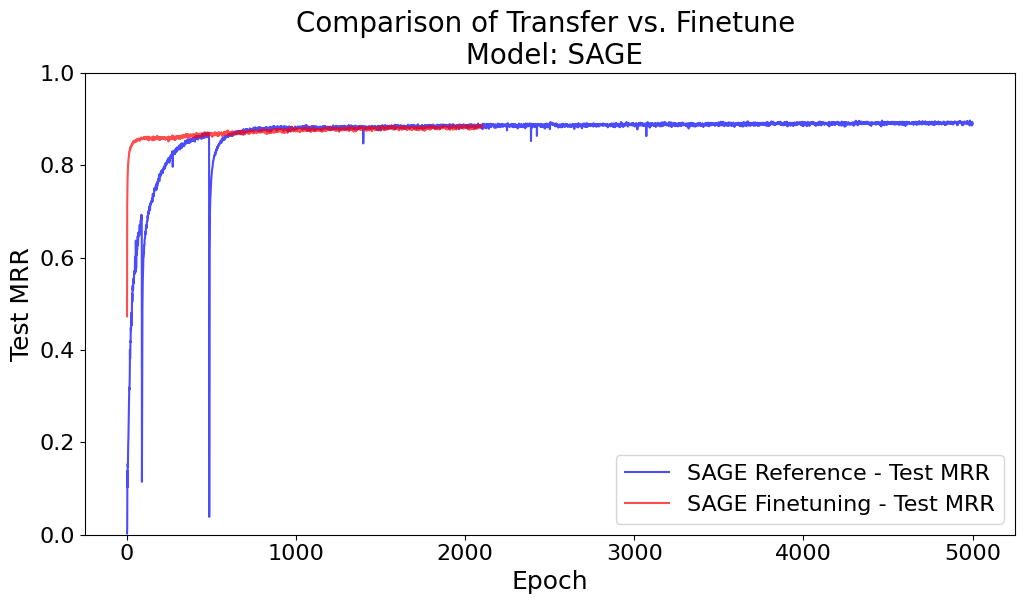

In [49]:
sns.lineplot(gin_df[gin_df["metricName"] == "test_mrr"],x="epoch",y="metricValue", label="SAGE Reference - Test MRR",color="blue",alpha=0.7)
sns.lineplot(gin_df_fine[gin_df_fine["metricName"] == "test_mrr"],x="epoch",y="metricValue", label="SAGE Finetuning - Test MRR",color="red",alpha=0.7)
plt.ylim(0,1)
plt.xlabel('Epoch')
plt.ylabel('Test MRR')
plt.title("Comparison of Transfer vs. Finetune \n Model: SAGE")
plt.legend()
plt.show()

## Standard Deviation Reference Models
Calculation of the standard deviation (model variability) of the gcn reference models.

In [ ]:
# get all results
experiment_ids = {'GCN arXiv CS Ref 1':'f48a4e67ea8846a0b3d2ca7e674aca95',
                  'GCN arXiv CS Ref 2':'c4f5985ba24e4c93b569dde82ce15a78',
                  'GCN arXiv CS Ref 3':'942c73672d59449c8a051796ae7f0e49',
                  'GCN arXiv CS Ref 4':'54dba56b65814a4fb588b03d32d61cf6',
                  'GCN arXiv CS Ref 5':'38ea03024c92483aabcf420fa960d293',
                  }
workspace = "swiggy123"
project_name = "link-prediction"

experiment_data = get_experiments_data(workspace=workspace,project_name=project_name,experiment_ids=experiment_ids)
results_data = get_experiments_results_data(workspace=workspace,project_name=project_name,experiment_ids=experiment_ids)

In [ ]:
# best values from above
valid_mrr_values = [0.8484336733818054, 0.8499453663825989, 0.8459517359733582, 0.8498203158378601, 0.8487957119941711]
test_mrr_values = [0.844505250453949, 0.8478335738182068, 0.8422207236289978, 0.8466485142707825, 0.8474210500717163]
valid_mrr_mean = np.round(np.mean(valid_mrr_values),4)
valid_mrr_std = np.round(np.std(valid_mrr_values),4)
test_mrr_mean = np.round(np.mean(test_mrr_values),4)
test_mrr_std = np.round(np.std(test_mrr_values),4)

# get mean valid and test mrr for the 5 runs
print(f"Valid mean MRR: {valid_mrr_mean} ({valid_mrr_std})")
print(f"Test mean MRR: {test_mrr_mean} ({test_mrr_std})")

In [ ]:
# get train val mrr difference over all epochs per run
for i in range(0,5):
    df_fine_val_train_mrr = experiment_data[i]['metrics']
    df_fine_val_train_mrr = df_fine_val_train_mrr[df_fine_val_train_mrr["metricName"].isin(["train_mrr","valid_mrr"])]
    print(np.round(np.mean(np.array(df_fine_val_train_mrr.pivot(columns=["metricName"])['metricValue']['valid_mrr'],dtype=float) - np.array(df_fine_val_train_mrr.pivot(columns=["metricName"])['metricValue']['train_mrr'],dtype=float)),4))


In [ ]:
# plot the 5 runs with an interval
# Combine all runs into a single DataFrame
all_metrics = pd.concat([run['metrics'] for run in experiment_data])

# Convert metricValue to float
all_metrics['metricValue'] = all_metrics['metricValue'].astype(float)

# Group by epoch and metricName to calculate mean and std
agg_metrics = all_metrics.groupby(['epoch', 'metricName']).agg(
    mean_metricValue=('metricValue', 'mean'),
    std_metricValue=('metricValue', 'std')
).reset_index()

plt.figure(figsize=(10, 6))

# Plotting train_mrr with std
train_mrr = agg_metrics[agg_metrics['metricName'] == 'train_mrr']
sns.lineplot(data=train_mrr, x="epoch", y="mean_metricValue", label="train_mrr", color="green")
plt.fill_between(train_mrr['epoch'], 
                 train_mrr['mean_metricValue'] - train_mrr['std_metricValue'],
                 train_mrr['mean_metricValue'] + train_mrr['std_metricValue'],
                 color="green", alpha=0.2)

# Plotting valid_mrr with std
valid_mrr = agg_metrics[agg_metrics['metricName'] == 'valid_mrr']
sns.lineplot(data=valid_mrr, x="epoch", y="mean_metricValue", label="valid_mrr", color="blue")
plt.fill_between(valid_mrr['epoch'], 
                 valid_mrr['mean_metricValue'] - valid_mrr['std_metricValue'],
                 valid_mrr['mean_metricValue'] + valid_mrr['std_metricValue'],
                 color="blue", alpha=0.2)

# Plotting valid_mrr with std
test_mrr = agg_metrics[agg_metrics['metricName'] == 'test_mrr']
sns.lineplot(data=test_mrr, x="epoch", y="mean_metricValue", label="test_mrr",linestyle="dashed", color="red")
plt.fill_between(test_mrr['epoch'], 
                 test_mrr['mean_metricValue'] - test_mrr['std_metricValue'],
                 test_mrr['mean_metricValue'] + test_mrr['std_metricValue'],
                 color="red", alpha=0.2)


plt.xlabel('Epochs')
plt.ylabel('MRR')
plt.title('arXiv CS reference GCN - MRR Curves')
plt.legend()
plt.show()


## Finetuning (Transfer Learning Metrics)
Calculation the transfer metrics jumpstar, asymptotic performance and transfer ratio.

In [94]:
# test_mrr_mean is the mean of the best epochs of the reference model
jumpstart_test_gcn = firstepoch_test_mrr_gcn_fine - firstepoch_test_mrr_gcn_ref
asyperf_test_gcn = finalepoch_test_mrr_gcn_fine - finalepoch_test_mrr_gcn_ref
transferratio_test_gcn = (finalepoch_test_mrr_gcn_fine - finalepoch_test_mrr_gcn_ref) / finalepoch_test_mrr_gcn_ref
print(f"GCN: \nJumpstart: {jumpstart_test_gcn}, Asymptotic Performance: {asyperf_test_gcn}, Transfer Ratio: {transferratio_test_gcn}")

jumpstart_test_gin = firstepoch_test_mrr_gin_fine - firstepoch_test_mrr_gin_ref
asyperf_test_gin = finalepoch_test_mrr_gin_fine - finalepoch_test_mrr_gin_ref
transferratio_test_gin = (finalepoch_test_mrr_gin_fine - finalepoch_test_mrr_gin_ref) / finalepoch_test_mrr_gin_ref
print(f"GIN: \nJumpstart: {jumpstart_test_gin}, Asymptotic Performance: {asyperf_test_gin}, Transfer Ratio: {transferratio_test_gin}")

jumpstart_test_sage = firstepoch_test_mrr_sage_fine - firstepoch_test_mrr_sage_ref
asyperf_test_sage = finalepoch_test_mrr_sage_fine - finalepoch_test_mrr_sage_ref
transferratio_test_sage = (finalepoch_test_mrr_sage_fine - finalepoch_test_mrr_sage_ref) / finalepoch_test_mrr_sage_ref
print(f"SAGE: \nJumpstart: {jumpstart_test_sage}, Asymptotic Performance: {asyperf_test_sage}, Transfer Ratio: {transferratio_test_sage}")


GCN: 
Jumpstart: -0.0032328632660210133, Asymptotic Performance: 0.0537877082824707, Transfer Ratio: 0.06465216490769775
GIN: 
Jumpstart: 0.005469669587910175, Asymptotic Performance: -0.09226536750793457, Transfer Ratio: -0.104286604442803
SAGE: 
Jumpstart: 0.0032328632660210133, Asymptotic Performance: -0.09090650081634521, Transfer Ratio: -0.10290875017686664
